<a href="https://colab.research.google.com/github/chadi-aebi/DMML2021_Rolex/blob/main/code/Notebook_Rolex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> UNIL Team Rolex

<h2> 0.1 Preparation to start working - import necessary methods etc.


**Remarks from Slack:** Basically we want to have your baseline solutions in that table. So without any data cleaning and pre-processing, who would the models mentioned in the table would perform (for each model you are also supposed to do hyper-parameter optimization to find the best hyper-parameters). This will give you the baseline accuracies that you can try to improve further by doing data preprocessing/cleaning or by using other models

In [1]:
#Install and update spacy
!pip install -U spacy
#Download the french language model
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 10.1 MB 31.2 MB/s 
     |████████████████████████████████| 181 kB 55.6 MB/s 
     |████████████████████████████████| 628 kB 42.6 MB/s 
     |████████████████████████████████| 451 kB 50.4 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 17.4 M

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import csv
import time

In [3]:
#Classifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Other
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from spacy import displacy
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr import French

<h2> 0.2 Further preparations to starkt with classification

Set random_seed, Vectorizers without preprocessing and load the french language model



In [4]:
np.random_seed = 0

In [5]:
#Set TF-IDF and Count Vectorizer without any more specifications
tfidf_vector = TfidfVectorizer()
count_vector = CountVectorizer()
#with preprocessing
#tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)


In [6]:
#Load the french language model
nlp = spacy.load('fr_core_news_sm')

In [49]:
#Import stop words from french language model and puncutations
stop_words=spacy.lang.fr.stop_words.STOP_WORDS
punctuations = string.punctuation

In [69]:
#Create a tokenizer function that later can be used for preprocessing the data for classification

def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    ## alternative way
    # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    #mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens

<h2> Getting started - text analytics per classifier
<h3> 1. Baseline

First, we start by calculating the baseline.

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
X = data['sentence']
ylabels = data['difficulty']
print(ylabels.value_counts(normalize=True))

A1    0.169375
C2    0.168125
C1    0.166250
A2    0.165625
B1    0.165625
B2    0.165000
Name: difficulty, dtype: float64


<h3> 2. Logistic Regression
<h4> 2.1 Logistic Regression without any data cleaning or tuning

In [ ]:
lr_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
lr_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')
lr_data.shape

(4800, 2)

In [ ]:
X_lr = lr_data['sentence']
ylabels_lr = lr_data['difficulty']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, ylabels_lr, test_size=0.2, random_state=0, stratify=ylabels)

In [ ]:
# Define classifier
lreg = LogisticRegression()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', lreg)])

# Fit model on training set
pipe.fit(X_train_lr, y_train_lr)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3d1ee16200>)),
                ('classifier', LogisticRegression())])

In [ ]:
# Predictions
y_pred_lr = pipe.predict(X_test_lr)

accuracy_score(y_test_lr,y_pred_lr)


0.41354166666666664

<h4> 2.2 Logistic Regression with hyperparameters tuning

<h4> 2.3 Logistic Regression with preprocessing 

<h3> 3. kNN
<h4> 3.1 kNN without any data cleaning or tuning
 

In [ ]:
knn_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
knn_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')

In [ ]:
X_knn = knn_data['sentence']
ylabels_knn = knn_data['difficulty']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, ylabels_knn, test_size=0.2, random_state=0, stratify=ylabels)

In [ ]:
# Define classifier
knn = KNeighborsClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Fit model on training set
pipe.fit(X_train_knn, y_train_knn)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3d1ee16200>)),
                ('classifier', KNeighborsClassifier())])

In [ ]:
y_pred_knn = pipe.predict(X_test_knn)

accuracy_score(y_test_knn,y_pred_knn)

0.171875

<h4> 3.2 kNN with hyperparameter tuning


<h4> 3.3 kNN with preprocessing

<h3> 4. Decision Tree
<h4> 4.1 Decision Tree without any data cleaning

In [ ]:
tree_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
tree_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')

In [ ]:
X_tree = tree_data['sentence']
ylabels_tree = tree_data['difficulty']

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, ylabels_tree, test_size=0.2, random_state=0, stratify=ylabels)

In [ ]:
# Define classifier
tree = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', tree)])

# Fit model on training set
pipe.fit(X_train_tree, y_train_tree)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3d1ee16200>)),
                ('classifier', DecisionTreeClassifier())])

In [ ]:
y_pred_tree = pipe.predict(X_test_tree)

accuracy_score(y_test_tree,y_pred_tree)

0.35208333333333336

<h4> 4.2 Decision Tree with hyperparameter tuning

<h4> 4.3 Decision Tree with preprocessing

<h3> 5. Random Forest
<h4> 5.1 Random Forest without any data cleaning


In [8]:
from sklearn.model_selection import RandomizedSearchCV

In [54]:
rf_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
rf_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')
rf_test_df.head()

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."


In [55]:
#stop_words

In [56]:
X_rf = rf_data['sentence']
ylabels_rf = rf_data['difficulty']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, ylabels_rf, test_size=0.2, random_state=0, stratify=ylabels_rf)

In [ ]:
X_train_rf_df = pd.DataFrame(X_train_rf)

In [ ]:
# Define classifier
rfc = RandomForestClassifier()

In [ ]:

# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', rfc)])

# Fit model on training set
pipe.fit(X_train_rf, y_train_rf)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [ ]:
y_pred_rf = pipe.predict(X_test_rf)

accuracy_score(y_test_rf,y_pred_rf)

<h4> 5.2 Random Forest with Hyperparameter Tuning

In [17]:
#Tuning Hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [500, 666, 833, 1000, 1166, 1333, 1500, 1666, 1833, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [18]:
#Crossvalidation
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=0, n_jobs = -1)

# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', rf_random)])

# Fit model on training set
pipe.fit(X_train_rf, y_train_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomizedSearchCV(cv=5,
                                    estimator=RandomForestClassifier(bootstrap=False,
                                                                     max_depth=70,
                                                                     min_samples_split=10,
                                                                     n_estimators=1166),
                                    n_jobs=-1,
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                                         'max_depth': [10, 20,
                                                                       30, 40,
                                                                       50, 60,
                                                                       70, 80,
        

In [21]:
#Save and display best parameters
best_param_1 = rf_random.best_params_
best_param_1

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1166}

In [20]:
y_pred_rf = pipe.predict(X_test_rf)

accuracy_score(y_test_rf,y_pred_rf)

0.41354166666666664

<h4> 5.3 Random Forest with preprocessing

<h5> 5.3.1 Set tokenizer with preprocessing methods

In [ ]:
tfidf_vec_rf = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Define classifier with best params - 07.12.2021 #1
#rfc = RandomForestClassifier('bootstrap': False,
 #'max_depth': 80,
 #'max_features': 'auto',
 #'min_samples_leaf': 1,
 #'min_samples_split': 10,
 #'n_estimators': 916)

# Create pipeline with tfidf
#pipe = Pipeline([('vectorizer', count_vector),
                 #('classifier', rfc)])

# Fit model on training set
#pipe.fit(X_train_rf, y_train_rf)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier())])

In [11]:
# Define classifier with best params - 07.12.2021 #2
rfc = RandomForestClassifier(bootstrap=False,
 max_depth= 70,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 1166)



In [12]:
# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', rfc)])

# Fit model on training set
pipe.fit(X_train_rf, y_train_rf)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=70,
                                        min_samples_split=10,
                                        n_estimators=1166))])

In [13]:
y_pred_rf = pipe.predict(X_test_rf)

accuracy_score(y_test_rf,y_pred_rf)

0.4197916666666667

In [14]:
y_pred_test=pipe.predict(rf_test_df['sentence'])


In [15]:
submission_test = pd.DataFrame(y_pred_test, columns=['difficulty'])
submission_test

,difficulty
0,C1
1,B1
2,A1
3,A1
4,C2
...,...
1195,B1
1196,A2
1197,C2
1198,A1


In [16]:

submission_test.to_csv('submission_21-12-10.csv')

<h5> 5.3.2 Word Embeddings

In [ ]:
#Vectorizing - Word Embeddings
with nlp.disable_pipes():
    vectors = np.array([nlp(lang.sentence).vector for idx, lang in X_train_rf_df.iterrows()])
    
vectors.shape

(3840, 96)

In [ ]:
#pipe = Pipeline([
                # ('rfc', rfc),
                # ])

# Fit model
#start = time.time()
#pipe.fit(vectors, y_train_rf)
#end = time.time()
#print('Time: ', round(end-start, 4))
#print('Train Accuracy: ', round(pipe.score(vectors, y_train_rf), 4))
#print('Test Accuracy: ', round(pipe.score(vectors, y_test_rf), 4))

Time:  59.3139
Train Accuracy:  1.0


ValueError: ignored

In [31]:
#Doc2Vec
from gensim.models.doc2vec import TaggedDocument
sample_tagged = rf_data.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['sentence']), tags=[r.difficulty]), axis=1)

In [32]:
train_tagged_rf, test_tagged_rf = train_test_split(sample_tagged, test_size = 0.2, random_state = 0)

In [33]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [34]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
model_dbow.build_vocab([x for x in train_tagged_rf.values])

In [35]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged_rf, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [36]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, regressors

y_train_rf, X_train_rf = vec_for_learning(model_dbow, train_tagged_rf)
y_test_rf, X_test_rf = vec_for_learning(model_dbow, test_tagged_rf)

0.426


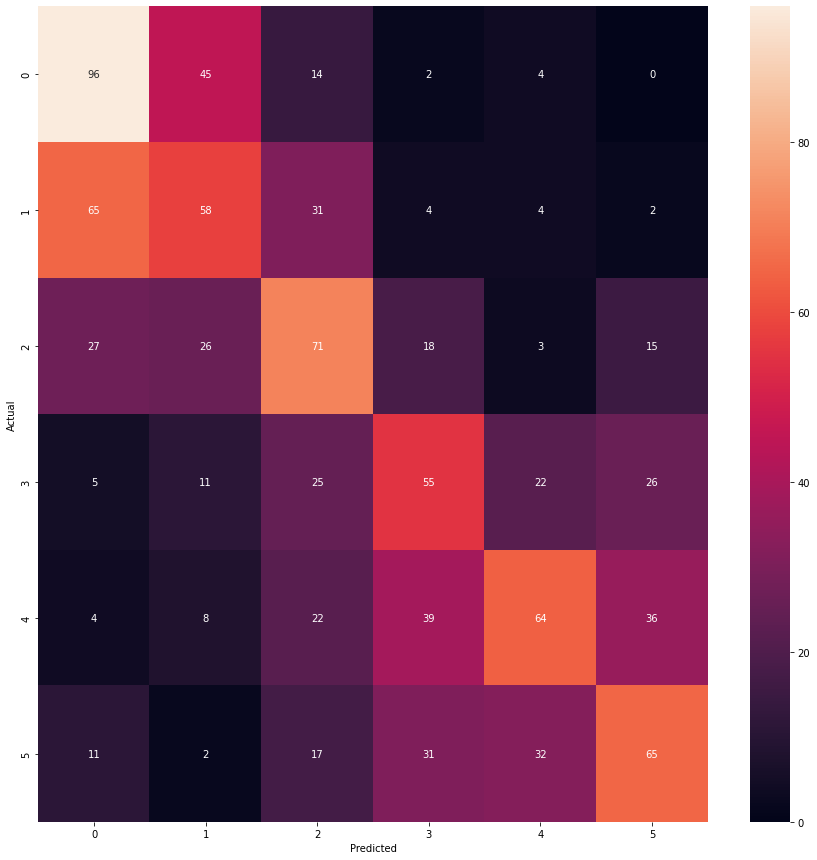

In [40]:
# Fit model on training set - same algorithm as before
rfc.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf = rfc.predict(X_test_rf)

# Evaluate model
print(round(accuracy_score(y_test_rf, y_pred_rf), 4))
conf_mat = confusion_matrix(y_test_rf, y_pred_rf)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<h5> 5.3.3 Dimensionality Reduction

In [ ]:
pca = PCA(n_components=200) 

In [ ]:
X_train_vec_rf = tfidf_vector.fit_transform(X_train_rf).toarray()
X_test_vec_rf = tfidf_vector.transform(X_test_rf).toarray()
print(X_train_vec_rf.shape)
X_train_vec_rf

(3840, 12903)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#build pipe without Scaler & PCA
scaler = StandardScaler()
pipe = Pipeline([
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

Time:  374.275
Train Accuracy:  0.9893
Test Accuracy:  0.4219


In [ ]:
#build pipe with  StandardScaler
scaler = StandardScaler()
pipe = Pipeline([
                 ('scaler', scaler),
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

Time:  511.6351
Train Accuracy:  0.9893
Test Accuracy:  0.4167


In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

Time:  124.2285
Train Accuracy:  0.9984
Test Accuracy:  0.3969


In [ ]:
#build pipe with PCA & StandardScaler

pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

Time:  111.3727
Train Accuracy:  0.9982
Test Accuracy:  0.3927


<h5> 5.3.4 Preprocessing



In [57]:
# Define classifier with best params - 07.12.2021 #2
rfc = RandomForestClassifier(bootstrap=False,
 max_depth= 70,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 1166)


In [70]:
#using spacy tokenizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [71]:
# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', rfc)])

# Fit model on training set
pipe.fit(X_train_rf, y_train_rf)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f7467ecde60>)),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=70,
                                        min_samples_split=10,
                                        n_estimators=1166))])

In [72]:
y_pred_rf = pipe.predict(X_test_rf)

accuracy_score(y_test_rf,y_pred_rf)

0.4625

In [73]:
y_pred_test = pipe.predict(rf_test_df['sentence'])

In [74]:
submission_test = pd.DataFrame(y_pred_test, columns=['difficulty'])
submission_test.to_csv('submission_21-12-10_2.csv')